<a href="https://colab.research.google.com/github/csaqueton/SSNMF-Explainability-Model/blob/main/Final_SSNMF_%2B_Full_Movie_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability for MovieLens Dataset

 [MovieLens](https://movielens.org/) dataset available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

 SSNMF approach: Semi-Supervised Non-negative Matrix Factorization
 
 [SSNMF GitHub](https://github.com/jamiehadd/ssnmf)


## Imports

In [ ]:
from __future__ import print_function
from __future__ import division
!pip install ssnmf

import itertools
import decimal

import random
import ssnmf
import seaborn as sns
from ssnmf import SSNMF
from ssnmf import visualization
import scipy.sparse as sparse
import scipy.optimize

import numpy as np
import pandas as pd
import collections
from collections import Counter

from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-ue288cd3
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-ue288cd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp37-none-any.whl size=732213 sha256=a88aba290364aaa46375aae911916bd318ebd59977ac36150e14ebf07e373f88
  Stored in directory: /tmp/pip-ephem-wheel-cache-izz7qw50/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
Done installing Altair.


## Load the MovieLens Data

In [ ]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.01): # changed from 0.1
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


## Build a tf.SparseTensor representation of the Rating Matrix.

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Error function

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

## CFModel helper class

This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']


In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

##Build a Matrix Factorization model and train it

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  
  return CFModel(embeddings, train_loss, [metrics])

  

## Running matrix factorization on Ratings dataframe



In [ ]:
#(1)
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)
print(model)


TypeError: ignored

## Obtain matrices for SSNMF

Matrices needed & their dimensions:
- X = 30 x 1682 = old features x movies
- Y = 19 x 1682 = genres x movies
- B = 19 x 12 = genres x topics
- S = 12 x 1682 = topics x movies
- A = 30 x 12 = old features x topics

### Construct the labels matrix (Y)

In [ ]:
#print(movielens)
Finalmodel = movielens.drop_duplicates(subset=['movie_id'])
Finalmodel['movie_id'] = pd.to_numeric(Finalmodel['movie_id'])
Sortedmodel = Finalmodel.sort_values(by=['movie_id'], ascending=True, ignore_index=True)
#print(Sortedmodel)
labelmat = Sortedmodel.iloc[:, 8:27].to_numpy()
print(labelmat)

[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Since some movies have more than 1 genre, 2 approaches:**

*1. Run this cell to randomly select one genre per movie*

In [ ]:
labelmat = labelmat.astype(float)
rowCount = 0
for row in labelmat:
  count = 0
  list = []
  for cell in row:
    if cell == 1:
      list.append(count) # save the indices of the cells that have a 1 one in them
    count += 1

  if not len(list) == 0:
    random_index = random.choice(list) # get a random 1's index
  
  # loop through row's cells again
  count = 0
  for cell in row:
    if count != random_index:
      labelmat[rowCount:count] = 0
    count += 1
  #labelmat[rowCount] = row
  rowCount += 1
print("labelmat with 1 genre per movie")
print(labelmat)

labelmat with 1 genre per movie
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


*2. Or... Consider the weight of all genres by averaging the rows of the labelsMatrix*

In [ ]:
count = 0
labelmat = labelmat.astype(float)
for row in labelmat:
  numOfOne = 0
  for cell in row:
    if cell == 1:
      numOfOne+= 1
  mult = 1 / numOfOne 
  labelmat[count] = row * mult
  count += 1
print(labelmat)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.25 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.5  0.   ... 0.   0.   0.  ]]


**Finalize labelsMatrix:**

In [ ]:
labelmat = labelmat.transpose()
print('Shape of Y:')
print(labelmat.shape)

Shape of Y:
(1682, 19)


### Construct all other matrices

In [ ]:
# Set number of topics (this can be manipulated)
k = 15

# Construct X:
X = model.embeddings["movie_id"] # numpy array
print(X)
print('Shape of X: ')
print(X.shape)
X = X.transpose()
print('Shape of X: ')
#print(X.shape)
#print(X)

# Construct B:
B = sparse.random(19,k,density=0.2).toarray()
print('Shape of B: ')
print(B.shape)

# Construct S:
S = np.zeros([k,1682]) 
print('Shape of S: ')
print(S.shape)

# Construct A:
A = np.random.rand(30,k)
print('Shape of A: ')
print(A.shape)

AttributeError: ignored

### Obtain list of old feature embeddings

In [ ]:
OldFeatureNames = []
count = 1
for row in X: 
  name = 'Old Feature ' + str(count)
  OldFeatureNames.append(name)
  count += 1
print(OldFeatureNames)

['Old Feature 1', 'Old Feature 2', 'Old Feature 3', 'Old Feature 4', 'Old Feature 5', 'Old Feature 6', 'Old Feature 7', 'Old Feature 8', 'Old Feature 9', 'Old Feature 10', 'Old Feature 11', 'Old Feature 12', 'Old Feature 13', 'Old Feature 14', 'Old Feature 15', 'Old Feature 16', 'Old Feature 17', 'Old Feature 18', 'Old Feature 19', 'Old Feature 20', 'Old Feature 21', 'Old Feature 22', 'Old Feature 23', 'Old Feature 24', 'Old Feature 25', 'Old Feature 26', 'Old Feature 27', 'Old Feature 28', 'Old Feature 29', 'Old Feature 30']


 ## Run SSNMF

In [ ]:
# 1. Call on SSNMF function
for i in range(k):
    S[:,i] = scipy.optimize.nnls(B,labelmat[:,i])[0]

model = SSNMF(X,k,Y = labelmat,lam=1000*np.linalg.norm(X,'fro'),modelNum=3, tol =.001)
A0 = model.A
S0 = model.S

# 2. Access factor matrices initialized in the model to check relative reconstruction error and classification accuracy
rel_error = model.fronorm(model.X, model.A, model.S, model.W)**2/model.fronorm(model.X, A0, S0, model.W)**2
acc = model.accuracy()
print("the initial relative reconstruction error is ", rel_error)
print("the initial classifier's accuracy is ", acc)

# 3. Minimize the objective function
N = 100
[errs,reconerrs,classerrs,classaccs] = model.mult(numiters = N,saveerrs = True)

# 4. Check how relative reconstruction error and classification accuracy improve
size = reconerrs.shape[0]
rel_error = reconerrs[size - 1]**2/model.fronorm(model.X, A0, S0, model.W)**2
acc = classaccs[size - 1]
print("number of iterations that this model runs: ", size)
print("the final relative reconstruction error is ", rel_error)
print("the final classifier's accuracy is ", acc)

the initial relative reconstruction error is  1.0
the initial classifier's accuracy is  0.059453032104637336
number of iterations that this model runs:  29
the final relative reconstruction error is  0.014333260443840489
the final classifier's accuracy is  0.6367419738406659


## Construct heatmaps to visualize explainability

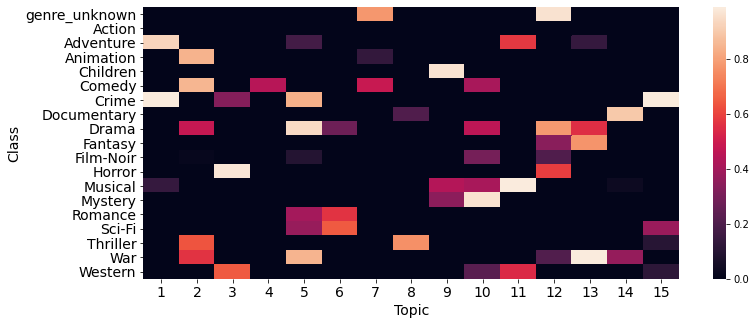

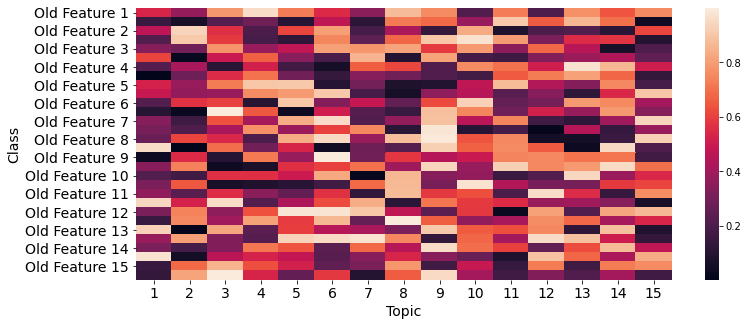

In [ ]:
 def factors_heatmaps(B, genre_cols, save=False, filepath = None):
    """
    Plot heatmap of the classifier coefficient matrix, shape (classes, topics).
    Args:
        B (ndarray): classifier coefficient matrix (classes, topics)
        cls_names (list): class labels (str)
        save (boolean): True to save figure, False otherwise
        filepath (str): save figure in filepath.
    """

    fig,ax = plt.subplots(figsize=(12,5))
    sns.heatmap(B)
    plt.xlabel('Topic', fontsize=14)
    plt.ylabel('Class', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, rotation= 0)

    ax.set_yticklabels(genre_cols)
    labels_x = [i+1 for i in range(B.shape[1])]
    ax.set_xticklabels(labels_x)

    if save == False:
        plt.savefig(filepath, bbox_inches='tight')
    #plt.show()
  
factors_heatmaps(B, genre_cols, save=True)
factors_heatmaps(A, OldFeatureNames, save = True)

# Interpreting explainability

What we have now:
- Topics link old features to genres

How to connect the dots:
- Old features trace back to topics which group together genres
- Each movie corresponds to some old features
- A movie recommendation is explained by its old features which is now explainable by genres

## Find each topic's primary genres:

In [ ]:
BTrans = B.transpose()
count = 1
for row in BTrans:
  Bdict = {}
  genre = 0
  for col in row:
    Bdict[genre_cols[genre]] = col
    genre += 1
  highest = dict(Counter(Bdict).most_common(3))
  highestList = list(highest.keys())
  print('Topic ' + str(count) + "'s Top 3 Genres are: " + str(highestList))
  count += 1

TypeError: ignored

## Find each old feature's primary topics:

In [ ]:
count = 1
for row in A:
  Adict = {}
  topic = 1
  for col in row:
    Adict['Topic '+str(topic)] = col
    topic += 1
  highest = dict(Counter(Adict).most_common(3))
  highestList = list(highest.keys())
  print('Old Feature ' + str(count) + "'s Top 3 Topics are: " + str(highestList))
  count += 1

Old Feature 1's Top 3 Topics are: ['Topic 11', 'Topic 6', 'Topic 4']
Old Feature 2's Top 3 Topics are: ['Topic 14', 'Topic 12', 'Topic 6']
Old Feature 3's Top 3 Topics are: ['Topic 7', 'Topic 2', 'Topic 1']
Old Feature 4's Top 3 Topics are: ['Topic 9', 'Topic 15', 'Topic 8']
Old Feature 5's Top 3 Topics are: ['Topic 4', 'Topic 8', 'Topic 2']
Old Feature 6's Top 3 Topics are: ['Topic 2', 'Topic 6', 'Topic 1']
Old Feature 7's Top 3 Topics are: ['Topic 3', 'Topic 9', 'Topic 5']
Old Feature 8's Top 3 Topics are: ['Topic 2', 'Topic 4', 'Topic 1']
Old Feature 9's Top 3 Topics are: ['Topic 13', 'Topic 6', 'Topic 2']
Old Feature 10's Top 3 Topics are: ['Topic 12', 'Topic 2', 'Topic 4']
Old Feature 11's Top 3 Topics are: ['Topic 1', 'Topic 3', 'Topic 11']
Old Feature 12's Top 3 Topics are: ['Topic 1', 'Topic 5', 'Topic 8']
Old Feature 13's Top 3 Topics are: ['Topic 15', 'Topic 6', 'Topic 2']
Old Feature 14's Top 3 Topics are: ['Topic 14', 'Topic 8', 'Topic 15']
Old Feature 15's Top 3 Topics are

## Find each movie's primary old features:

In [ ]:
XTrans = X.transpose()
print(X)
count = 1
for row in XTrans: # for each movie
  Xdict = {}
  oldFeature = 0
  for col in row: # for each old feature of that movie
    Xdict[OldFeatureNames[oldFeature]] = col
    oldFeature += 1
  highest = dict(Counter(Xdict).most_common(3))
  highestList = list(highest.keys())
  print('Movie ' + str(count) + "'s Top 3 Old Features are: " + str(highestList))
  count += 1

[[-0.54474443  0.29919368  0.1270272  ... -0.18756722  0.5103447
  -0.7629308 ]
 [-0.28597057 -0.08385433 -0.04530452 ... -0.00381409  0.4983429
  -0.39335036]
 [ 0.12528846  0.00795132 -0.06379706 ...  0.5163603  -0.06570695
   0.39498824]
 ...
 [-0.57591045 -0.5087856  -0.14915854 ... -0.616263   -0.33359078
   0.8650687 ]
 [-1.0516161  -0.15354003 -0.96848583 ... -0.6259106   0.38799128
   0.4300891 ]
 [ 0.47763565 -0.26672015  0.8781731  ...  0.16955309 -0.6228136
  -0.64703935]]
Movie 1's Top 3 Old Features are: ['Old Feature 6', 'Old Feature 25', 'Old Feature 23']
Movie 2's Top 3 Old Features are: ['Old Feature 6', 'Old Feature 23', 'Old Feature 8']
Movie 3's Top 3 Old Features are: ['Old Feature 6', 'Old Feature 23', 'Old Feature 30']
Movie 4's Top 3 Old Features are: ['Old Feature 5', 'Old Feature 7', 'Old Feature 6']
Movie 5's Top 3 Old Features are: ['Old Feature 23', 'Old Feature 18', 'Old Feature 30']
Movie 6's Top 3 Old Features are: ['Old Feature 6', 'Old Feature 18', 'Ol

## Our TO-DO:

- scanner to ask user which topic/old feature/movie they want to check


- indicate possible modes of exploration (ie. div/div -> matrix is more sparse)
- Show what genres are in each movie
- present how we made all decisions in the process
- Conversion box: indicate what's what in terms of ssnmf
